In [2]:
import genome
from genome import Genom, Node
import numpy as np
import operator
import copy
from time import sleep

In [2]:
genom = Genom(2,1)

In [3]:
genom.p_nodes()
genom.p_connections()

===== Input Nodes =====
Key: -2 Type: input Bias: 0
Key: -1 Type: input Bias: 0
===== Hidden Nodes =====
===== Output Nodes =====
Key: 0 Type: out Bias: 0

===== Connections =====
-2 --> 0 Weight: -0.9318220774839996 is active : True
-1 --> 0 Weight: -1.022892596627269 is active : True



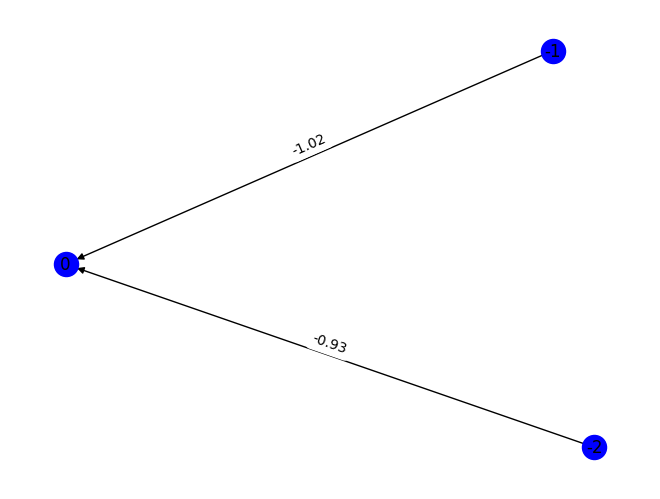

In [4]:
genom.visualize()

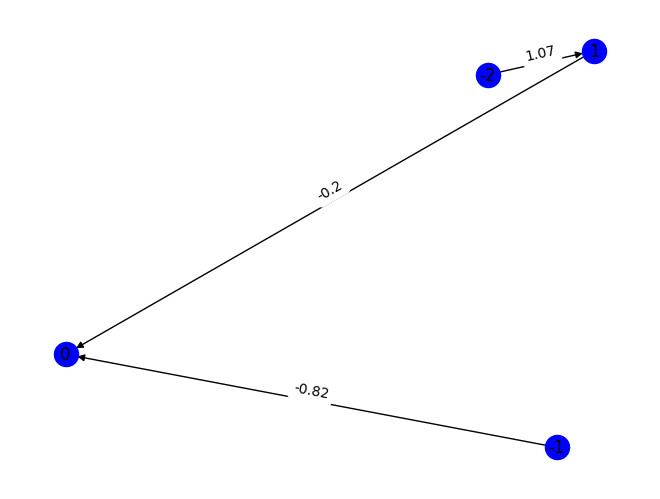

In [5]:
for _ in range(10):
    genom.mutate()
genom.visualize(labels=True)

In [6]:
genom.p_nodes()
genom.p_connections()

===== Input Nodes =====
Key: -2 Type: input Bias: 0
Key: -1 Type: input Bias: 0
===== Hidden Nodes =====
Key: 1 Type: hidden Bias: 0
===== Output Nodes =====
Key: 0 Type: out Bias: 0

===== Connections =====
-1 --> 0 Weight: -0.8205595794980327 is active : True
-2 --> 1 Weight: 1.074431032586542 is active : True
1 --> 0 Weight: -0.198650721217491 is active : True



In [7]:
genom.forward([1,1])

[(0, -1.0339960790198028)]

In [8]:
def same_connection(con1,con2):
        return con1.in_Node.key == con2.in_Node.key and con1.out_Node.key == con2.out_Node.key

def contains_connection(con,l_cons):
    for c in l_cons:
        if same_connection(c,con):
            return True
        
    return False

In [9]:
def crossover(genom1,genom2):

        con1 = genom1.connections
        con2 = genom2.connections

        fit1 = np.random.rand(1)
        fit2 = np.random.rand(1)


        new_con = []
        for c1 in con1:
            for c2 in con2:
                if same_connection(c1,c2):
                    if c1.is_active == c2.is_active:
                        if np.random.rand(1) < 0.5:
                            new_con.append(c1)
                        else:
                            new_con.append(c2)
                        break
                    elif fit1 >= fit2:
                        new_con.append(c1)
                    else:
                        new_con.append(c2)

        if fit1 >= fit2:
            for c1 in con1:
                if not contains_connection(c1, new_con):
                    new_con.append(c1)
        else:
            for c2 in con2:
                if not contains_connection(c2, new_con):
                    new_con.append(c2)

        g = Genom(2,1)
        g.in_Nodes = genom1.in_Nodes
        g.out_Nodes = genom1.out_Nodes
        g.hidden_Nodes = genom1.hidden_Nodes if fit1 > fit2 else genom2.hidden_Nodes
        g.connections = new_con
        g.visualize()

        return g

In [10]:
genom1 = Genom(2,1)
genom2 = Genom(2,1)

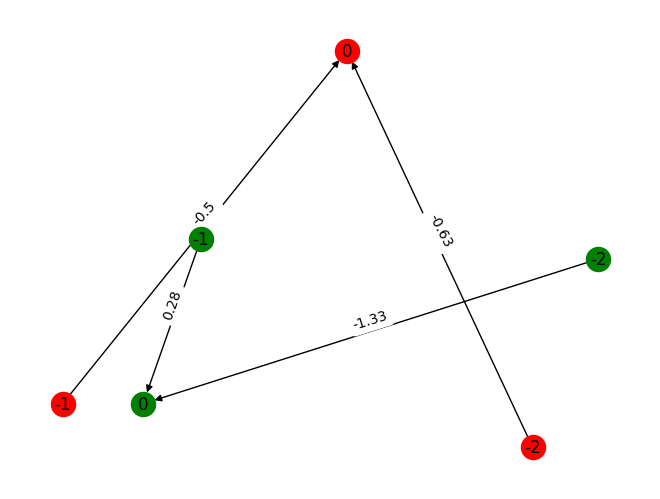

In [11]:
genom1.visualize(color="red")
genom2.visualize(color="green")

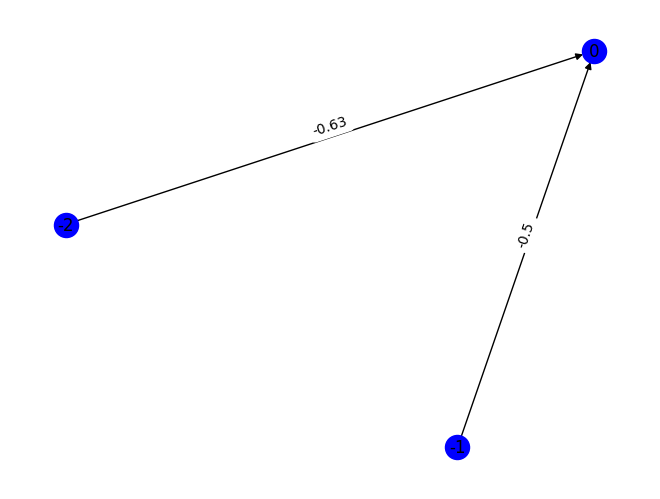

In [12]:
crossover(genom1,genom2)

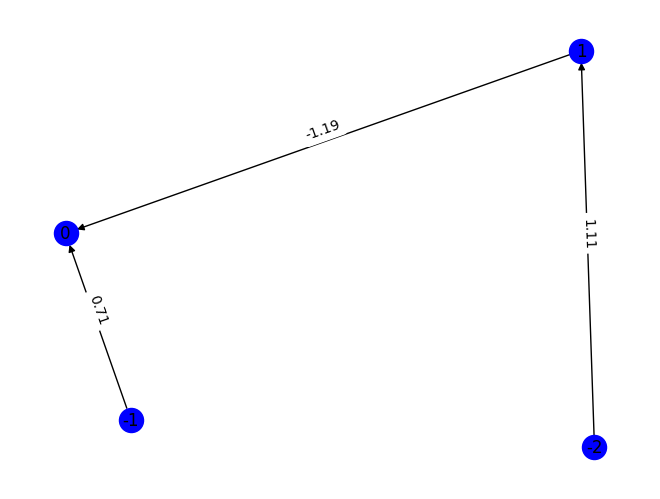

In [13]:
for _ in range(10):
    genom2.mutate()

genom2.visualize()

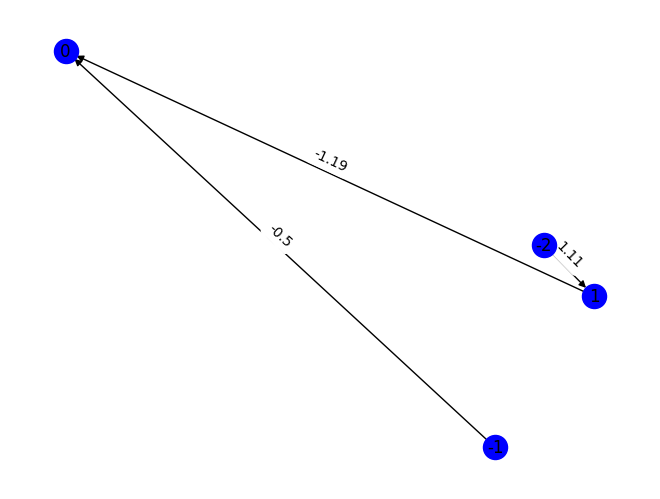

In [14]:
g = crossover(genom1,genom2)

In [15]:
g.forward([0,1])
g.p_connections()

===== Connections =====
-1 --> 0 Weight: -0.5017779183334417 is active : True
-2 --> 1 Weight: 1.1102093069111472 is active : True
1 --> 0 Weight: -1.1867774947888776 is active : True



In [16]:
class NN():

    def __init__(self, popSize = 2, n_In = 2, n_Out = 1) -> None:
        self.population = [(Genom(n_In,n_Out),0) for _ in range(popSize)] 
        self.popSize = popSize

    def forwardpass(self, index,x):
        return self.population[index][0].forward(x)

    def mutate(self,pop):
        for p in pop:
            p[0].mutate()

    def same_connection(self,con1,con2):
        return con1.in_Node.key == con2.in_Node.key and con1.out_Node.key == con2.out_Node.key

    def contains_connection(self,con,l_cons):
        for c in l_cons:
            if self.same_connection(c,con):
                return True
            
        return False
    
    def cross(self, genom1, genom2, fit1, fit2):

        con1 = genom1.connections
        con2 = genom2.connections


        new_con = []
        for c1 in con1:
            for c2 in con2:
                if self.same_connection(c1,c2):
                    if c1.is_active == c2.is_active:
                        if np.random.rand(1) < 0.5:
                            new_con.append(c1)
                        else:
                            new_con.append(c2)
                        break
                    elif fit1 >= fit2:
                        new_con.append(c1)
                    else:
                        new_con.append(c2)

        if fit1 >= fit2:
            for c1 in con1:
                if not self.contains_connection(c1, new_con):
                    new_con.append(c1)
        else:
            for c2 in con2:
                if not self.contains_connection(c2, new_con):
                    new_con.append(c2)

        g = Genom(2,1)
        g.in_Nodes = genom1.in_Nodes
        g.out_Nodes = genom1.out_Nodes
        hidden_Nodes = []
        hidden_keys = []
        for c in new_con:
            if not c.in_Node.key in hidden_keys and c.in_Node.type == "hidden":
                hidden_keys.append(c.in_Node.key)
                hidden_Nodes.append(Node(c.in_Node.key))
            if not c.out_Node.key in hidden_keys and c.out_Node.type == "hidden":
                hidden_keys.append(c.out_Node.key)
                hidden_Nodes.append(Node(c.out_Node.key))

        g.hidden_Nodes = hidden_Nodes
        g.connections = new_con
        g.n_nodes = len(g.out_Nodes) + len(g.hidden_Nodes)
        #g.visualize()

        return g

    
    def crossover(self):
        idx = [i for i in range(len(self.population))]
        np.random.shuffle(idx)

        child_pop = []

        for i in range(0,len(idx),2):
            child_pop.append((self.cross(self.population[i][0],self.population[i+1][0],self.population[i][1],self.population[i+1][1]),0))
        return child_pop

    def selection(self):
        sortedPop = sorted(self.population, key=operator.itemgetter(1), reverse=True)
        self.population = sortedPop[:self.popSize]

    def fitness(self):
        for i in range(len(self.population)):
            tmp = 0

            if np.round(self.population[i][0].forward([0,0])[0][1]) == 0:
                tmp += 0.25
            if np.round(self.population[i][0].forward([0,1])[0][1]) == 1:
                tmp += 0.25
            if np.round(self.population[i][0].forward([1,0])[0][1]) == 1:
                tmp += 0.25
            if np.round(self.population[i][0].forward([1,1])[0][1]) == 0:
                tmp += 0.25
            #print(genom.forward([0,0]))

            t = list(self.population[i])
            t[1] = tmp
            self.population[i] = tuple(t)

            
    
    def train(self, epochs = 100):
        i = 0
        while True:
            i+=1
            print("Epoch: " + str(i), end=" ")
            print("Acc: " +str(self.population[0][1]))

            if(self.population[0][1] == 1):
               return self.population[0][0]
            '''for p in self.population:
                p[0].p_nodes()
                p[0].p_connections()'''

            child_pop = self.crossover()
            self.mutate(child_pop)
            self.population += child_pop

            self.fitness()
            self.selection()

        return self.population[0][0]


            
            
            
            

In [17]:
nn = NN(popSize=100)
g = nn.train()
g.visualize()


Epoch: 1 Acc: 0
Epoch: 2 Acc: 0.75
Epoch: 3 Acc: 0.75
Epoch: 4 Acc: 0.75
Epoch: 5 Acc: 0.75
Epoch: 6 Acc: 0.75
Epoch: 7 Acc: 0.75
Epoch: 8 Acc: 0.75
Epoch: 9 Acc: 0.75
Epoch: 10 Acc: 0.75
Epoch: 11 Acc: 0.75
Epoch: 12 Acc: 0.75
Epoch: 13 Acc: 0.75
Epoch: 14 Acc: 0.75
Epoch: 15 Acc: 0.75
Epoch: 16 Acc: 0.75
Epoch: 17 Acc: 0.75
Epoch: 18 Acc: 0.75
Epoch: 19 Acc: 0.75
Epoch: 20 Acc: 0.75
Epoch: 21 Acc: 0.75
Epoch: 22 Acc: 0.75
Epoch: 23 Acc: 0.75
Epoch: 24 Acc: 0.75
Epoch: 25 Acc: 0.75
Epoch: 26 Acc: 0.75
Epoch: 27 Acc: 0.75
Epoch: 28 Acc: 0.75
Epoch: 29 Acc: 0.75
Epoch: 30 Acc: 0.75
Epoch: 31 Acc: 0.75
Epoch: 32 Acc: 0.75
Epoch: 33 Acc: 0.75
Epoch: 34 Acc: 0.75
Epoch: 35 Acc: 0.75
Epoch: 36 Acc: 0.75
Epoch: 37 Acc: 0.5
Epoch: 38 Acc: 0.75
Epoch: 39 Acc: 0.75
Epoch: 40 Acc: 0.75
Epoch: 41 Acc: 0.75
Epoch: 42 Acc: 0.75
Epoch: 43 Acc: 0.75
Epoch: 44 Acc: 0.75
Epoch: 45 Acc: 0.75
Epoch: 46 Acc: 0.75
Epoch: 47 Acc: 0.75
Epoch: 48 Acc: 0.75
Epoch: 49 Acc: 0.75
Epoch: 50 Acc: 0.75
Epoch: 51 Acc

Traceback (most recent call last):
  File "C:\Users\timds\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\timds\AppData\Local\Temp\ipykernel_30004\1385331174.py", line 2, in <module>
    g = nn.train()
        ^^^^^^^^^^
  File "C:\Users\timds\AppData\Local\Temp\ipykernel_30004\1225026811.py", line 126, in train
    self.fitness()
  File "C:\Users\timds\AppData\Local\Temp\ipykernel_30004\1225026811.py", line 93, in fitness
    if np.round(self.population[i][0].forward([0,0])[0][1]) == 0:
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\timds\OneDrive\Desktop\Master\Semester 2\NE\neuroevolution-1\genome.py", line -1, in forward
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\timds\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiv

In [21]:
print(g.forward([0,0]))
print(g.forward([0,1]))
print(g.forward([1,0]))
print(g.forward([1,1]))

[(0, -0.0)]
[(0, -0.5017779183334417)]
[(0, -1.3175714199473074)]
[(0, -1.819349338280749)]


In [6]:
k = 0
for i in range(1,1000000000):
    x = np.random.rand(1)
    y = np.random.rand(1)
    if x**2 + y**2 <= 1:
        k+=1

print(4*k/i)

3.134231342313423
